# Deep Learning Assignment - 8
# Name: Sahana Thoravalli PRabhuswamy
# Github link to assignment
https://github.com/SahanaTP/DeepLearningAssignments

# Importing the required libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

# Reading the Google stock .csv file

In [25]:
data = pd.read_csv('/content/Google_Stock_Price_Train.csv')

In [ ]:
data

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


# Plotting the open values of Google stock price

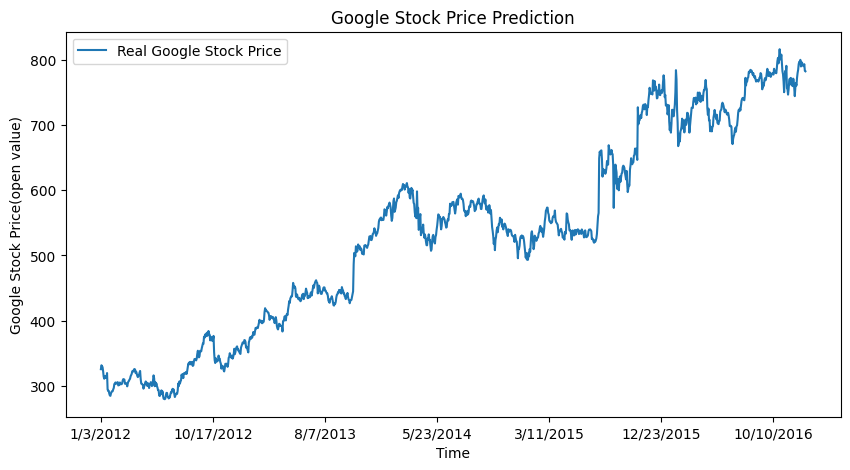

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(data.loc[:, 'Date'],data.iloc[:,1:2].values, label = 'Real Google Stock Price')
plt.xticks(np.arange(0,1258,200))
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price(open value)')
plt.legend()
plt.show()

In [16]:
# train set size(80%)
train_size = round(data.shape[0]*0.8)
test_size = len(data)-train_size
print('train_size: ', train_size, ', test_size: ', test_size)

train_size:  1006 , test_size:  252


# Splitting data into train(80%) and test(20%)

In [17]:
training_set = data.iloc[:1006, 1:2].values
test_set = data.iloc[1006:, 1:2].values

In [18]:
training_set.shape, test_set.shape

((1006, 1), (252, 1))

# Transforming a time series dataset into a prediction dataset

In [19]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

lookback = 4
X_train, y_train = create_dataset(training_set, lookback=lookback)
X_test, y_test = create_dataset(test_set, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([1002, 4, 1]) torch.Size([1002, 4, 1])
torch.Size([248, 4, 1]) torch.Size([248, 4, 1])


<ipython-input-19-9005952916bc>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# LSTM model with hidden_size=70 means that there are 70 features in hidden state, Number of layers is 2 meaning its a stacked LSTM model with 2 layers deep

In [15]:
class my_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=70, num_layers=2, batch_first=True)
        self.linear = nn.Linear(70, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

# training LSTM with hyperparameter:
# Optimizer = Adam and loss = MSE lose, batch size = 8

In [22]:
model = my_LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
epochs = []
train_rmse_list = []
test_rmse_list = []

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    epochs.append(epoch)
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

Epoch 0: train RMSE 482.9000, test RMSE 730.8602
Epoch 100: train RMSE 130.4492, test RMSE 274.3314
Epoch 200: train RMSE 15.7277, test RMSE 62.5373
Epoch 300: train RMSE 12.1836, test RMSE 31.6118
Epoch 400: train RMSE 8.5092, test RMSE 20.1225
Epoch 500: train RMSE 10.2758, test RMSE 22.1709
Epoch 600: train RMSE 8.5885, test RMSE 18.9827
Epoch 700: train RMSE 8.7292, test RMSE 19.3457
Epoch 800: train RMSE 10.3853, test RMSE 20.1720
Epoch 900: train RMSE 8.9502, test RMSE 20.0324
Epoch 1000: train RMSE 8.8093, test RMSE 21.7514
Epoch 1100: train RMSE 10.1759, test RMSE 21.4323
Epoch 1200: train RMSE 8.0995, test RMSE 17.3808
Epoch 1300: train RMSE 8.0989, test RMSE 17.7515
Epoch 1400: train RMSE 8.2910, test RMSE 17.5040
Epoch 1500: train RMSE 8.3712, test RMSE 19.1438
Epoch 1600: train RMSE 8.0807, test RMSE 17.7293
Epoch 1700: train RMSE 8.4970, test RMSE 18.3299
Epoch 1800: train RMSE 8.8681, test RMSE 17.8895
Epoch 1900: train RMSE 8.9473, test RMSE 18.0427


# Plotting the training and test losses for different epochs

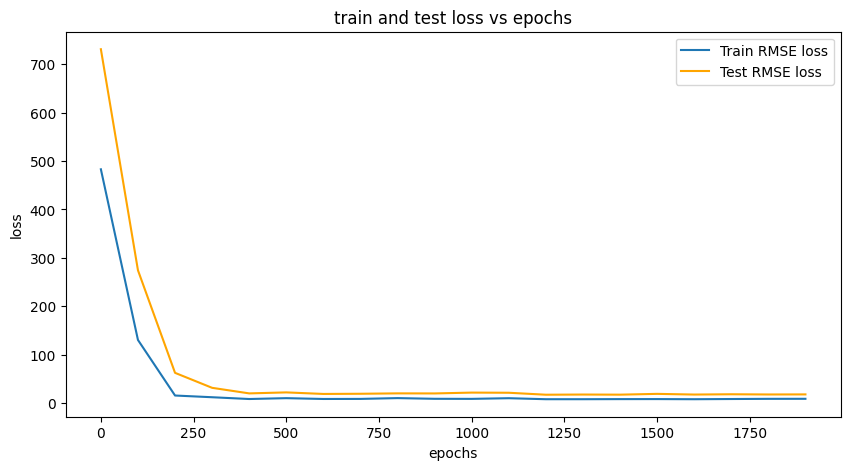

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_rmse_list, label = 'Train RMSE loss')
plt.plot(epochs, test_rmse_list, color = 'orange', label = 'Test RMSE loss')
plt.title('train and test loss vs epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# It can be seen that both test and train losses are decreasing and it is almost constant after a few hundred epochs.

# Plotting the train and test predictions along with actual stock values

In [26]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(data.iloc[:,1:2].values) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(data.iloc[:,1:2].values) * np.nan
    test_plot[train_size+lookback:len(data.iloc[:,1:2].values)] = model(X_test)[:, -1, :]


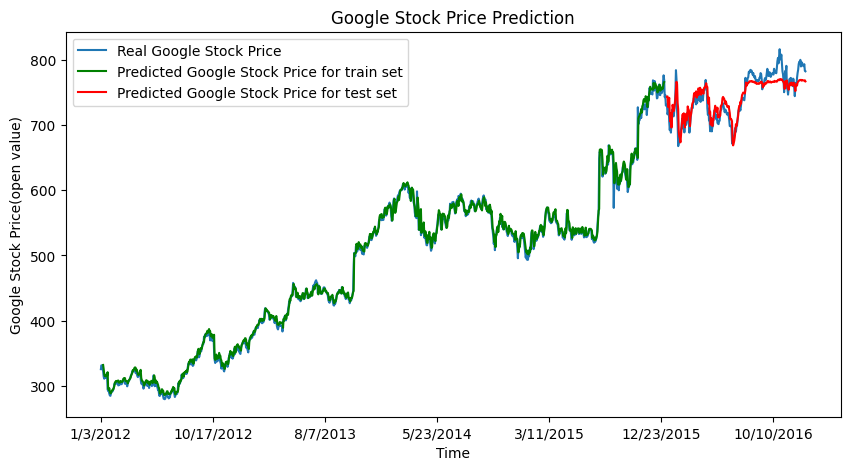

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(data.loc[:, 'Date'],data.iloc[:,1:2].values, label = 'Real Google Stock Price')
plt.plot(data.loc[:, 'Date'],train_plot, color = 'green', label = 'Predicted Google Stock Price for train set')
plt.plot(data.loc[:, 'Date'],test_plot, color = 'red', label = 'Predicted Google Stock Price for test set')
plt.xticks(np.arange(0,1258,200))
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price(open value)')
plt.legend()
plt.show()

# Result interpretation:

* The LSTM model is performing very well for train data and for test data there is an RNSE of ~17 after 2000 epochs.
* From the above Google stock price prediction plot it can be seen that for lower values of test data the model is performing more accurately then the higher values of test data
* LSTM model is trained only on open values to predict the next days open values but in reality, the stock market is volatile and may depend on many attributes and the model may not be accurate


